In [2]:
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/Users/miguelibarra/.miniconda3/envs/cin/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Set working directory
os.chdir("..") # Go one level up
os.getcwd()

'/Users/miguelibarra/PycharmProjects/cin'

In [58]:
# Read in cropped nuclei predictions
mn_predict = pd.read_csv("predictions/predictions_lindsay_all.csv")
# Read in cropped nuclei labeld by lindsay
mn_labeled = pd.read_csv("labels/labels_lindsay_complete.csv")

In [59]:
mn_labeled["name"] = mn_labeled["image"].apply(lambda x: "_".join([x.split("/")[-1].split(".")[0].replace("Snap-","").replace("_new",""), x.split("_")[-1].replace(".png", "")]))
mn_labeled["micronuclei"] = mn_labeled["label"].astype(bool).astype(int)
mn_labeled = mn_labeled[["name", "micronuclei"]]

In [60]:
threshold = 0.85
mn_predict["name"] = mn_predict["image"].apply(lambda x: "_".join([x.split(".")[0].replace("Snap-","").replace("_new",""), x.split("_")[-1].replace(".png","")]))
mn_predict["micronuclei"] = (mn_predict["prediction"] > threshold).astype(int)
mn_predict = mn_predict[["name", "micronuclei"]]

In [61]:
# Merge data
comparable_bb = pd.merge(mn_predict, mn_labeled, on="name", suffixes=["_predicted", "_labeled"])
comparable_bb["file"] = comparable_bb["name"].apply(lambda x: x.split("_")[0]).astype(str)
comparable_bb

,name,micronuclei_predicted,micronuclei_labeled,file
0,1974_0,0,0,1974
1,1974_1,0,0,1974
2,1974_2,0,0,1974
3,1974_3,0,0,1974
4,1974_4,0,0,1974
...,...,...,...,...
2713,2401_4,0,0,2401
2714,2401_5,0,0,2401
2715,2401_6,0,0,2401
2716,2401_7,0,0,2401


In [62]:
# Read in well-file info
well_file = pd.read_csv("original_well_file.csv", index_col=0, dtype={"file":str})

In [63]:
# Add well information
comparable_wells = pd.merge(well_file, comparable_bb, on="file")
comparable_wells

,well,file,name,micronuclei_predicted,micronuclei_labeled
0,A375 + dox,1985,1985_0,0,0
1,A375 + dox,1985,1985_10,0,0
2,A375 + dox,1985,1985_11,0,0
3,A375 + dox,1985,1985_2,0,0
4,A375 + dox,1985,1985_3,0,0
...,...,...,...,...,...
2713,A375 kif2c - dox,2107,2107_5,0,0
2714,A375 kif2c - dox,2107,2107_6,0,1
2715,A375 kif2c - dox,2107,2107_7,0,0
2716,A375 kif2c - dox,2107,2107_8,0,1


In [64]:
# Aggregate results by well
aggregated = pd.concat([d.sum()[["micronuclei_predicted", "micronuclei_labeled"]].rename(g) for g, d in comparable_wells.groupby("well")], axis=1).T
aggregated = aggregated.reset_index().rename(columns={"index": "well"})
aggregated

,well,micronuclei_predicted,micronuclei_labeled
0,A375 + dox,43,48
1,A375 - dox,83,86
2,A375 dnMCAK + dox,90,89
3,A375 dnMCAK - dox,45,48
4,A375 kif2a + dox,69,71
5,A375 kif2a - dox,46,43
6,A375 kif2c + dox,84,85
7,A375 kif2c - dox,68,79


In [65]:
aggregated_tall = aggregated.melt(id_vars=["well"], value_vars=["micronuclei_predicted", "micronuclei_labeled"], var_name="micronuclei_prediction", value_name="micronuclei")
aggregated_tall

,well,micronuclei_prediction,micronuclei
0,A375 + dox,micronuclei_predicted,43
1,A375 - dox,micronuclei_predicted,83
2,A375 dnMCAK + dox,micronuclei_predicted,90
3,A375 dnMCAK - dox,micronuclei_predicted,45
4,A375 kif2a + dox,micronuclei_predicted,69
5,A375 kif2a - dox,micronuclei_predicted,46
6,A375 kif2c + dox,micronuclei_predicted,84
7,A375 kif2c - dox,micronuclei_predicted,68
8,A375 + dox,micronuclei_labeled,48
9,A375 - dox,micronuclei_labeled,86


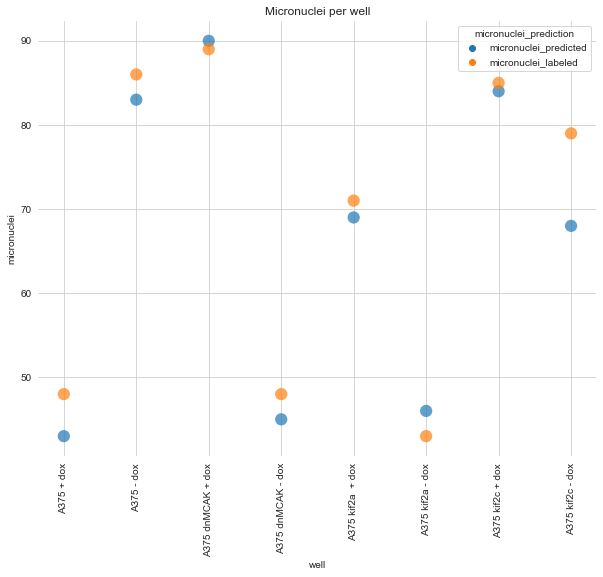

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_style("whitegrid")
sns.scatterplot(data=aggregated_tall, x="well", y="micronuclei", hue="micronuclei_prediction", s=150, linewidth=0, alpha=0.7)
sns.despine(left=True, bottom=True)
ax.set_title("Micronuclei per well")
ax.tick_params(axis='x', labelrotation=90)